In [1]:
import torch

In [2]:
from comet_ml import Experiment, Optimizer

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import sklearn
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [4]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score

In [5]:
from tabular_hypernet import HypernetworkPCA, TrainingModes, Hypernetwork
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface
# from ipynb.fs.defs.MNIST_benchmark import test_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [6]:
from sklearn.metrics import classification_report, balanced_accuracy_score

In [7]:
import pyhopper

In [8]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [9]:
import seaborn as sns

In [10]:
DEVICE="cuda:0"

In [11]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

2

In [12]:
GS_METRIC = 'balanced_accuracy'

# Load data

In [13]:
TEST_RUN = False

# Preprocess

In [14]:
def train_test_split_tuple(X, y, train_size=None):
    if isinstance(X, tuple) and isinstance(y, tuple):
        X_train, X_test = X
        y_train, y_test = y
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    
    return X_train, X_test, y_train, y_test

In [15]:
import imblearn
np.random.seed(42)

def prepare_data(X, y, size=None):
    if isinstance(X, tuple) and isinstance(y, tuple):
        X_train, X_test = X
        y_train, y_test = y
    else:    
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    # X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

## Benchmark

In [16]:
criterion = torch.nn.CrossEntropyLoss()

In [17]:
def _summarize_results(y_pred, y_score, y_test, labels):
    results = []
    for idx, label in enumerate(labels):
        y_pred_filt = y_pred[y_test==idx]
        y_test_filt = y_test[y_test==idx]
        acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
        results.append({
            "Class": label,
            "Metric": acc
        })
        
    acc = (y_pred==y_test.numpy()).sum()/len(y_test)*100    
    results.append({
        "Class": "Total",
        "Metric": acc
    })
    
    
    results.append({
        "Class": "balanced_accuracy",
        "Metric": balanced_accuracy_score(y_test, torch.from_numpy(y_pred)).item()*100
    })
    
    try:
        results.append({
            "Class": "F1 score",
            "Metric": f1_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "roc_auc",
            "Metric": roc_auc_score(y_test, torch.from_numpy(y_score[:, 1])).item()*100
        })
        results.append({
            "Class": "Precision",
            "Metric": precision_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
        results.append({
            "Class": "Recall",
            "Metric": recall_score(y_test, torch.from_numpy(y_pred)).item()*100
        })
    except ValueError:
        pass
    return results

def test_model(model_fn, data, train_size, label_encoder=None, iters=10, as_numpy=False):
    if TEST_RUN:
        iters = 1
        
    if label_encoder is not None:
        labels = label_encoder.classes_
    else:
        labels = sorted(pd.unique(data[1][0] if isinstance(data[1], tuple) else data[1]))

    
    results = []
    
    X, y = data

    for i in range(iters):
        X_train, X_test, y_train, y_test = prepare_data(*data, train_size)
        print('iter', i+1, 'of', iters, 'X_train shape', X_train.shape)

        model = model_fn()

        if as_numpy:
            model.fit(X_train.numpy(), y_train.numpy());
        else:
            model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)
        results.extend(_summarize_results(y_pred, y_score, y_test, labels))

    dframe = pd.DataFrame.from_dict(results)
    sns.violinplot(data=dframe[dframe["Class"]!="Loss"], y="Class", x="Metric", orient='h')
    return dframe

### Param search

In [18]:
def pyhopper_best_params(model_fn, param_grid, data, train_size, metric=GS_METRIC, time="30m", default_params={}):
    if TEST_RUN:
        time = 60
        if 'epochs' in param_grid:
            param_grid["epochs"] = pyhopper.choice([10])
    
    X, y = data
    print('pyhopper', X.shape, y.shape, train_size)
        
    def objective(params):
    #     print("Training...")
        print('params',params)
        model_results = test_model(
                        model_fn(
                            **default_params,
                            **params
                        ),
                        (X, y),
                        train_size,
                        None, 5)
        with open(f"{DATA}_{model_fn.__name__}_params.txt", "a") as f:
            f.write(str(params) + ", " + str(model_results[model_results["Class"]==metric]["Metric"].mean()) + "\n")
        return model_results[model_results["Class"]==metric]["Metric"].mean()

    from pyhopper.callbacks import History
    search = pyhopper.Search(param_grid)

    best_params = search.run(objective, "maximize", time, n_jobs="1x per-gpu", seeding_ratio=0.5)
    
    with open(f"{DATA}_{model_fn.__name__}_best_params.txt", "a") as f:
            f.write(str(best_params))
    
    print(f"{DATA}_{model_fn.__name__}_{best_params}")
    return best_params


In [19]:
d = {}

# TRAIN

# Ionosphere

In [20]:
DATA = "Ionosphere"

In [21]:
if DATA == "Ionosphere":
    ionosphere = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data', header=None)
    ionosphere = ionosphere.drop(1, axis=1)
    X = ionosphere.values[:, :-1].astype(float)
    y = ionosphere.values[:, -1]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(351, 33) 2
    GS_METRIC = "balanced_accuracy"



In [22]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 126, 1: 225}
n_classes 2
n_features 33


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 210
eval_max_size 280


In [24]:
X_train.shape

(280, 33)

In [25]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 32), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(32, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner

pyhopper (280, 33) (280,) 210


  0%|          | [00:00<?]

Search is scheduled for 01:30:00 (h:m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 50, 'mask_size': 25, 'target_size': 20, 'lr': 0.0003, 'batch_size': 64}
iter 1 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
params {'epochs': 150, 'masks_no': 50, 'mask_size': 15, 't

/home/z1157095/anaconda3/envs/hyper-mnist/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


iter 3 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 100, 'mask_size': 10, 'target_size': 10, 'lr': 0.03, 'batch_size': 64}
iter 1 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
params {'epochs': 150, 'masks_no': 100, 'mask_size': 2, 'target_size': 20, 'lr': 0.003, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([210, 33])
torch.Size([1, 128])
iter 4 of 5 X_train shape tor

{'epochs': 150,
 'masks_no': 50,
 'mask_size': 15,
 'target_size': 20,
 'lr': 0.003,
 'batch_size': 64}

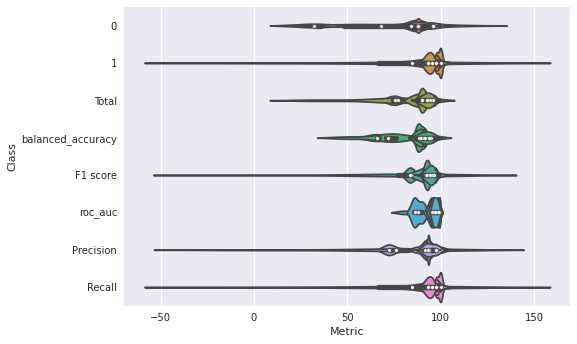

In [26]:

param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 80, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 15, 20, 25]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}
#{'epochs': 100, 'masks_no': 10, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="90m"
)
hp_best_params

iter 1 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


iter 2 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


iter 3 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:50<00:00,  1.35it/s]


iter 4 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:50<00:00,  1.36it/s]


iter 5 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


iter 6 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


iter 7 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:51<00:00,  1.35it/s]


iter 8 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:50<00:00,  1.35it/s]


iter 9 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:49<00:00,  1.36it/s]


iter 10 of 10 X_train shape torch.Size([280, 33])
torch.Size([1, 128])


100%|██████████| 150/150 [01:49<00:00,  1.37it/s]


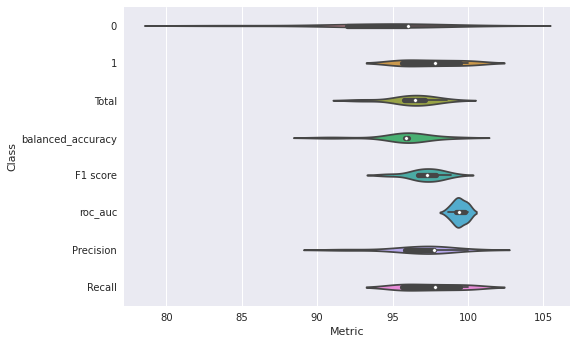

In [27]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']


hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, verbose=True),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [28]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

280: 96.34 ~ 1.51, (max: 98.59)


In [29]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

# Libras

In [30]:
DATA = "Libras"

In [31]:
if DATA == "Libras":
    libras = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/libras/movement_libras.data', header=None)
    X = libras.values[:, :-1].astype(float)
    y = libras.values[:, -1].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    #(360, 90) 15
    GS_METRIC = "balanced_accuracy"

In [32]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 24, 1: 24, 2: 24, 3: 24, 4: 24, 5: 24, 6: 24, 7: 24, 8: 24, 9: 24, 10: 24, 11: 24, 12: 24, 13: 24, 14: 24}
n_classes 15
n_features 90


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 216
eval_max_size 288


In [34]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 128), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(128, 256),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(256, 256),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

pyhopper (288, 90) (288,) 216


  0%|          | [00:00<?]

Search is scheduled for 02:00:00 (h:m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 5, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 2 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 3 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 4 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 5 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
params {'epochs': 100, 'masks_no': 80, 'mask_size': 70, 'target_size': 100, 'lr': 0.0003, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 2 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 3 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 4 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
iter 5 of 5 X_train shape torch.Size([216, 90])
torch.Size([1, 256])
params {'epochs': 150, 'masks_no': 200, 'mask_size': 10, 

{'epochs': 150,
 'masks_no': 200,
 'mask_size': 10,
 'target_size': 100,
 'lr': 0.03,
 'batch_size': 64}

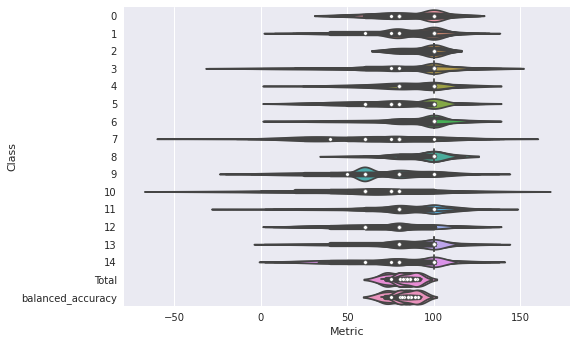

In [35]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 80, 100, 150, 200]),
    "mask_size": pyhopper.choice([5, 10, 15, 25, 50, 70]),
    "target_size": pyhopper.choice([5, 10, 20, 50, 100, 150]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="120m"
)
hp_best_params

iter 1 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 2 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 3 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 4 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 5 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 6 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 7 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 8 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 9 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])
iter 10 of 10 X_train shape torch.Size([288, 90])
torch.Size([1, 256])


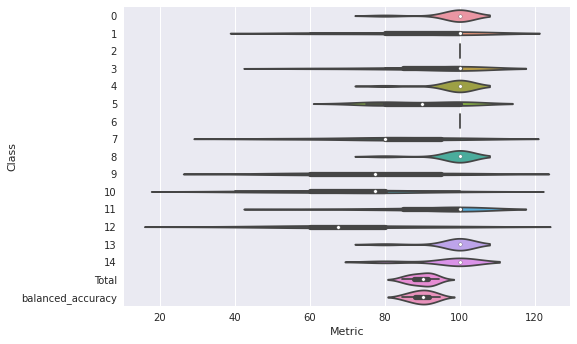

In [36]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']

hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [37]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

288: 89.86 ~ 3.14, (max: 94.44)


In [38]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

# Lymphography

In [39]:
DATA = "Lymphography"

In [40]:
if DATA == "Lymphography":
    lymphography = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/lymphography/lymphography.data', header=None)
    X = lymphography.values[:, 1:].astype(float)
    y = lymphography.values[:, 0].astype(int)
    y = LabelEncoder().fit_transform(y).astype(int)
    #(148, 18) 4
    GS_METRIC = "balanced_accuracy"

In [41]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 2, 1: 81, 2: 61, 3: 4}
n_classes 4
n_features 18


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 88
eval_max_size 118


In [43]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=False, lr=3e-4)
        return network
    return _inner

pyhopper (118, 18) (118,) 88


  0%|          | [00:00<?]

Search is scheduled for 03:00:00 (h:m:s)
params {'epochs': 100, 'masks_no': 10, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 16}
iter 1 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
params {'epochs': 150, 'masks_no': 10, 'mask_size': 5, 'target_size': 20, 'lr': 0.0003, 'batch_size': 16}
iter 1 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
params {'epochs': 150, 'masks_no': 100, 'mask_size': 5, 'target_size'

iter 2 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 10, 'mask_size': 5, 'target_size': 50, 'lr': 3e-05, 'batch_size': 64}
iter 1 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 20, 'mask_size': 7, 'target_size': 10, 'lr': 3e-05, 'batch_size': 16}
iter 1 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([88, 18])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([88, 

{'epochs': 150,
 'masks_no': 10,
 'mask_size': 7,
 'target_size': 50,
 'lr': 3e-05,
 'batch_size': 16}

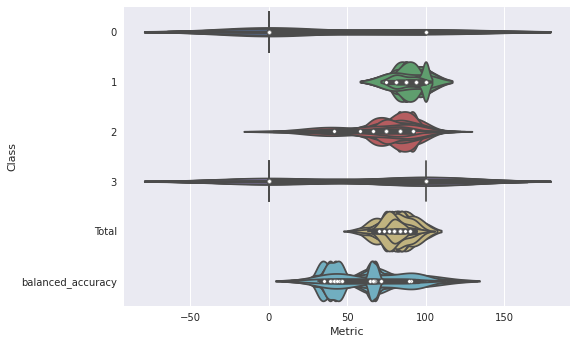

In [44]:
param_grid = {
    "epochs": pyhopper.choice([100, 150]),
    "masks_no": pyhopper.choice([10, 20, 50, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 7, 10, 15, 18]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([16, 32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="180m"
)
hp_best_params

iter 1 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])
iter 2 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 3 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 4 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 5 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 6 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 7 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 8 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 9 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


iter 10 of 10 X_train shape torch.Size([118, 18])
torch.Size([1, 128])


/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100
/tmp/ipykernel_297378/2619930025.py:6: RuntimeWarning: invalid value encountered in long_scalars
  acc = (y_pred_filt==y_test_filt.numpy()).sum()/len(y_test_filt)*100


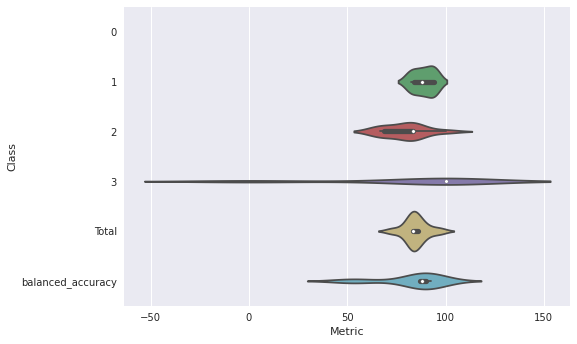

In [45]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
lr = hp_best_params['lr']
batch_size = hp_best_params['batch_size']

hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, lr=lr, batch_size=batch_size),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [46]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

118: 84.67 ~ 5.92, (max: 96.67)


In [47]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

# Hill-Valley-without-noise

In [48]:
DATA = "Hill-Valley-without-noise"

In [49]:
if DATA == "Hill-Valley-without-noise":
    hill_valley_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/Hill_Valley_without_noise_Training.data')
    hill_valley_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/Hill_Valley_without_noise_Testing.data')
    
    X_train = hill_valley_train.values[:, :-1].astype(float)
    y_train = hill_valley_train.values[:, -1]
    y_train = LabelEncoder().fit_transform(y_train).astype(int)
    
    X_test = hill_valley_test.values[:, :-1].astype(float)
    y_test = hill_valley_test.values[:, -1]
    y_test = LabelEncoder().fit_transform(y_test).astype(int)
    
    print('train', X_train.shape, len(np.unique(y_train)))
    print('test', X_test.shape, len(np.unique(y_test)))
    
    X = (X_train, X_test)
    y = (y_train, y_test)


train (606, 100) 2
test (606, 100) 2


In [50]:
n_classes = len(np.unique(y if not isinstance(y, tuple) else y_train))
n_features = X.shape[1] if not isinstance(X, tuple) else X_train.shape[1]
unique, counts = np.unique(y if not isinstance(y, tuple) else y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

{0: 305, 1: 301}
n_classes 2
n_features 100


In [51]:
X_train, X_test, y_train, y_test = train_test_split_tuple(X, y, train_size=0.8)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

train_max_size 454
eval_max_size 606


In [52]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([5, 10, 50, 70, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 20, 50, 90]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="300m"
)
hp_best_params

pyhopper (606, 100) (606,) 454


  0%|          | [00:00<?]

Search is scheduled for 05:00:00 (h:m:s)
params {'epochs': 100, 'masks_no': 5, 'mask_size': 2, 'target_size': 5, 'lr': 3e-05, 'batch_size': 32}
iter 1 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 150, 'mask_size': 50, 'target_size': 5, 'lr': 0.003, 'batch_size': 64}
iter 1 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 2 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 3 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 4 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
iter 5 of 5 X_train shape torch.Size([454, 100])
torch.Size([1, 128])
params {'epochs': 100, 'masks_no': 70, 'mask_size'

In [ ]:
epochs = hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
batch_size = hp_best_params['batch_size']
lr = hp_best_params['lr']


hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, batch_size=batch_size,verbose=True),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

# Hill-Valley-with-noise

In [ ]:
DATA = "Hill-Valley-with-noise"

In [ ]:
if DATA == "Hill-Valley-with-noise":
    hill_valley_train = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/Hill_Valley_with_noise_Training.data')
    hill_valley_test = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/hill-valley/Hill_Valley_with_noise_Testing.data')
    
    X_train = hill_valley_train.values[:, :-1].astype(float)
    y_train = hill_valley_train.values[:, -1]
    y_train = LabelEncoder().fit_transform(y_train).astype(int)
    
    X_test = hill_valley_test.values[:, :-1].astype(float)
    y_test = hill_valley_test.values[:, -1]
    y_test = LabelEncoder().fit_transform(y_test).astype(int)
    
    print('train', X_train.shape, len(np.unique(y_train)))
    print('test', X_test.shape, len(np.unique(y_test)))
    
    X = (X_train, X_test)
    y = (y_train, y_test)


In [ ]:
n_classes = len(np.unique(y if not isinstance(y, tuple) else y_train))
n_features = X.shape[1] if not isinstance(X, tuple) else X_train.shape[1]
unique, counts = np.unique(y if not isinstance(y, tuple) else y_train, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_tuple(X, y, train_size=0.8)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

In [ ]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([5, 10, 50, 70, 100, 150, 200]),
    "mask_size": pyhopper.choice([2, 5, 10, 20, 50, 90]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([32, 64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="300m"
)
hp_best_params

In [ ]:
epochs = 100#hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
batch_size = hp_best_params['batch_size']
lr = hp_best_params['lr']


hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, batch_size=batch_size,verbose=True),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

# cnae

In [ ]:
DATA = "cnae"

In [ ]:
if DATA == "cnae":
    cnae = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00233/CNAE-9.data', header=None)
    cnae = cnae.drop(1, axis=1)
    X = cnae.values[:, 1:].astype(float)
    y = cnae.values[:, 0]
    y = LabelEncoder().fit_transform(y).astype(int)
    #(1080, 855) 2

print(X.shape, len(np.unique(y)))

In [ ]:
n_classes = len(np.unique(y))
n_features = X.shape[1]
unique, counts = np.unique(y, return_counts=True)

print(dict(zip(unique, counts)))

print('n_classes', n_classes)
print('n_features', n_features)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

eval_max_size = int(len(X_train))
train_max_size = int(len(X_train) * 0.75)
print('train_max_size', train_max_size)
print('eval_max_size', eval_max_size)

In [ ]:
def network_hp_fn(epochs=150, masks_no=100, mask_size=100, target_size=100, lr=3e-4, batch_size=64, verbose=False):
    def _inner():
        hypernet = Hypernetwork(
                        target_architecture=[(mask_size, target_size), (target_size, n_classes)],
                        test_nodes=masks_no,
                        architecture=torch.nn.Sequential(torch.nn.Linear(n_features, 64), 
                            torch.nn.ReLU(),
                            torch.nn.Linear(64, 128),
                            torch.nn.ReLU(),
                            torch.nn.Dropout(),
                            torch.nn.Linear(128, 128),
                            torch.nn.ReLU(),
                        ),
                        mode=TrainingModes.CARTHESIAN,
                    ).to(DEVICE)    
        hypernet = hypernet.train()

        network = HypernetworkSklearnInterface(hypernet, device=DEVICE, epochs=epochs, batch_size=batch_size, verbose=verbose, lr=lr)
        return network
    return _inner


In [ ]:
param_grid = {
    "epochs": pyhopper.choice([100]),
    "masks_no": pyhopper.choice([3, 5, 10, 50, 75, 100, 150]),
    "mask_size": pyhopper.choice([5, 10, 20, 50, 100, 200, 400, 600, 750]),
    "target_size": pyhopper.choice([5, 10, 20, 50]),
    "lr": pyhopper.choice([3e-5, 3e-4, 3e-3, 3e-2, 3e-1]),
    "batch_size": pyhopper.choice([64]),
}

hp_best_params = pyhopper_best_params(
    network_hp_fn, param_grid, data=(X_train, y_train), train_size=train_max_size, time="480m"
)
hp_best_params

In [ ]:
epochs = 100#hp_best_params['epochs']
masks_no = hp_best_params['masks_no']
mask_size = hp_best_params['mask_size']
target_size = hp_best_params['target_size']
batch_size = hp_best_params['batch_size']
lr = hp_best_params['lr']


hyper_results = test_model(network_hp_fn(epochs, masks_no, mask_size, target_size, batch_size=batch_size,verbose=True),
                    (X, y),
                    eval_max_size,
                    None, 10)

In [ ]:
res = hyper_results[hyper_results["Class"]=="Total"].reset_index(drop=True)["Metric"]
print(f"{eval_max_size}: {res.mean():.2f} ~ {res.std():.2f}, (max: {res.max():.2f})")

In [ ]:
d[DATA] = hyper_results.groupby("Class")['Metric'].agg(['mean', 'std', 'max'])

In [ ]:
d